# MaxVSC_sw – Demo RMS VSC-HVDC (ENG-1.0)

Este cuaderno muestra cómo usar el simulador RMS VSC-HVDC
implementado en `maxvsc-sw` con los escenarios ULTRAestables
que definimos en `examples/`.

⚠️ **Requisitos:**

- Ejecutar este notebook desde la raíz del repo `maxvsc-sw`.
- Tener la carpeta `src/` con el paquete `vscsim/`.
- Tener los archivos de ejemplo:
  - `examples/params_ultrastable.json`
  - `examples/scenario_pq_ultrastable.json`
  - `examples/scenario_vdcq_ultrastable.json`

El notebook no modifica el núcleo del simulador; solo llama
a las funciones ya implementadas y genera gráficos.


In [2]:
from pathlib import Path
import sys

# Añadir 'src' al sys.path para poder importar vscsim
repo_root = Path.cwd()
src_path = repo_root / 'src'
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

print('Repo root:', repo_root)
print('sys.path[0]:', sys.path[0])


Repo root: c:\Users\ajrcj\MaxDEV Projects\MaxVSC_sw
sys.path[0]: c:\Users\ajrcj\MaxDEV Projects\MaxVSC_sw\src


In [4]:
import json
import matplotlib.pyplot as plt

from vscsim.io.parameters import load_parameters
from vscsim.io.initial_conditions import load_initial_conditions
from vscsim.solver.simulation import run_step

def load_json(path: Path) -> dict:
    with path.open('r', encoding='utf-8') as f:
        return json.load(f)


## Escenario ULTRAestable PQ – Paso pequeño de potencia

Usa `params_ultrastable.json` y `scenario_pq_ultrastable.json`.
Integra desde t=0 hasta t=0.5 s con dt=0.0005.


In [5]:
params_path = repo_root / 'examples' / 'params_ultrastable.json'
scenario_pq_path = repo_root / 'examples' / 'scenario_pq_ultrastable.json'

params_config = load_json(params_path)
scenario_cfg_pq = load_json(scenario_pq_path)

params = load_parameters(params_config)

t_end = 0.5
dt = 0.0005
n_steps = int(t_end / dt)

control_mode = scenario_cfg_pq['control_mode']
assert control_mode == 'PQ'

v_pcc_d = scenario_cfg_pq['v_pcc_d']
v_pcc_q = scenario_cfg_pq['v_pcc_q']

P_initial = scenario_cfg_pq['P_ref_initial']
Q_initial = scenario_cfg_pq['Q_ref_initial']

events_pq = scenario_cfg_pq.get('events', [])
if events_pq:
    step_time_pq = events_pq[0]['time']
    P_step = events_pq[0]['P_ref']
    Q_step = events_pq[0]['Q_ref']
else:
    step_time_pq = t_end + 1.0
    P_step = P_initial
    Q_step = Q_initial

ic = load_initial_conditions(scenario_cfg_pq.get('initial_conditions', {}))
x = dict(ic['x0'])
y = dict(ic['y0'])

t_pq = [0.0]
Vdc_pq = [x['Vdc']]
P_ref_pq = [P_initial]

t = 0.0
for k in range(n_steps):
    t = (k + 1) * dt

    if t < step_time_pq:
        P_ref = P_initial
        Q_ref = Q_initial
    else:
        P_ref = P_step
        Q_ref = Q_step

    scenario_inst = {
        'control_mode': 'PQ',
        'P_ref': P_ref,
        'Q_ref': Q_ref,
        'v_pcc_d': v_pcc_d,
        'v_pcc_q': v_pcc_q,
    }

    x, y = run_step(
        t=t,
        dt=dt,
        x=x,
        y=y,
        scenario=scenario_inst,
        params=params,
    )

    t_pq.append(t)
    Vdc_pq.append(x['Vdc'])
    P_ref_pq.append(P_ref)

print('PQ: Vdc(initial)=', Vdc_pq[0], 'Vdc(final)=', Vdc_pq[-1])


PQ: Vdc(initial)= 1.0 Vdc(final)= 1.1009011340756116


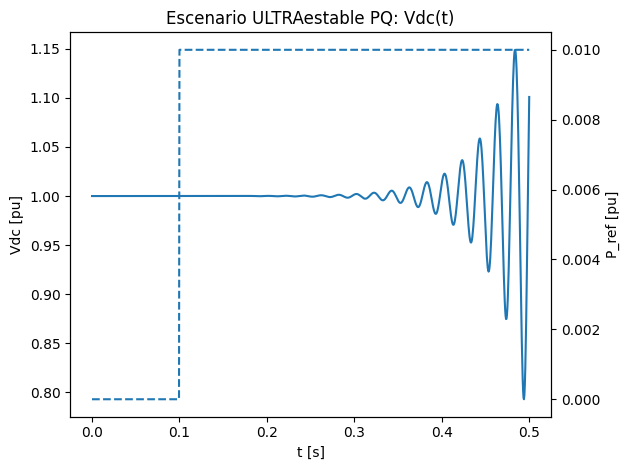

In [6]:
fig, ax1 = plt.subplots()
ax1.plot(t_pq, Vdc_pq)
ax1.set_xlabel('t [s]')
ax1.set_ylabel('Vdc [pu]')
ax1.set_title('Escenario ULTRAestable PQ: Vdc(t)')

ax2 = ax1.twinx()
ax2.plot(t_pq, P_ref_pq, linestyle='--')
ax2.set_ylabel('P_ref [pu]')

fig.tight_layout()
plt.show()


## Escenario ULTRAestable VdcQ – Paso pequeño de id_ref

Usa `params_ultrastable.json` y `scenario_vdcq_ultrastable.json`.
Integra desde t=0 hasta t=0.5 s con dt=0.0005.


In [7]:
scenario_vdcq_path = repo_root / 'examples' / 'scenario_vdcq_ultrastable.json'

scenario_cfg_vdcq = load_json(scenario_vdcq_path)

params = load_parameters(params_config)  # mismos parámetros

t_end = 0.5
dt = 0.0005
n_steps = int(t_end / dt)

control_mode = scenario_cfg_vdcq['control_mode']
assert control_mode == 'VdcQ'

v_pcc_d = scenario_cfg_vdcq['v_pcc_d']
v_pcc_q = scenario_cfg_vdcq['v_pcc_q']

id_initial = scenario_cfg_vdcq['id_ref_initial']
iq_initial = scenario_cfg_vdcq['iq_ref_initial']

events_vdcq = scenario_cfg_vdcq.get('events', [])
if events_vdcq:
    step_time_vdcq = events_vdcq[0]['time']
    id_step = events_vdcq[0]['id_ref']
    iq_step = events_vdcq[0]['iq_ref']
else:
    step_time_vdcq = t_end + 1.0
    id_step = id_initial
    iq_step = iq_initial

ic = load_initial_conditions(scenario_cfg_vdcq.get('initial_conditions', {}))
x = dict(ic['x0'])
y = dict(ic['y0'])

t_vdcq = [0.0]
Vdc_vdcq = [x['Vdc']]
id_ref_vdcq = [id_initial]

t = 0.0
for k in range(n_steps):
    t = (k + 1) * dt

    if t < step_time_vdcq:
        id_ref = id_initial
        iq_ref = iq_initial
    else:
        id_ref = id_step
        iq_ref = iq_step

    scenario_inst = {
        'control_mode': 'VdcQ',
        'id_ref': id_ref,
        'iq_ref': iq_ref,
        'v_pcc_d': v_pcc_d,
        'v_pcc_q': v_pcc_q,
    }

    x, y = run_step(
        t=t,
        dt=dt,
        x=x,
        y=y,
        scenario=scenario_inst,
        params=params,
    )

    t_vdcq.append(t)
    Vdc_vdcq.append(x['Vdc'])
    id_ref_vdcq.append(id_ref)

print('VdcQ: Vdc(initial)=', Vdc_vdcq[0], 'Vdc(final)=', Vdc_vdcq[-1])


VdcQ: Vdc(initial)= 1.0 Vdc(final)= 1.1009209394230661


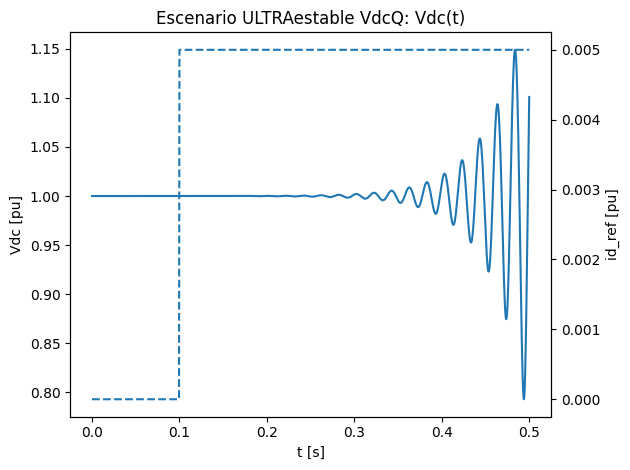

In [8]:
fig, ax1 = plt.subplots()
ax1.plot(t_vdcq, Vdc_vdcq)
ax1.set_xlabel('t [s]')
ax1.set_ylabel('Vdc [pu]')
ax1.set_title('Escenario ULTRAestable VdcQ: Vdc(t)')

ax2 = ax1.twinx()
ax2.plot(t_vdcq, id_ref_vdcq, linestyle='--')
ax2.set_ylabel('id_ref [pu]')

fig.tight_layout()
plt.show()
